Build Face Recognition for Face Mask Detection Desktop App using Python, TensorFlow 2, OpenCV,


In [ ]:
#import all libraries
import os
import numpy as np
import pandas as pd
import cv2
import gc
from tqdm import tqdm
from glob import glob

In [2]:
#collect all data and labelling
dirs=os.listdir('data/data')
images_path=[]
labels=[]
for folder in dirs:
    path=glob('./data/data/{}/*.jpg'.format(folder))
    label=['{}'.format(folder)]*len(path)
    images_path.extend(path)
    labels.extend(label)

In [3]:
images_path[1]

'./data/data/Mask\\00001.jpg'

In [4]:
#face Detection FP16
#Download model
img_path=images_path[1]
img=cv2.imread(img_path)

In [5]:
#cv2.imshow('orginal_image',img)
#cv2.waitKey()
#cv2.destroyAllWindows()

In [6]:
face_detection_model=cv2.dnn.readNetFromCaffe('./models-20220206T140731Z-001/models/deploy.prototxt.txt','./models-20220206T140731Z-001/models/res10_300x300_ssd_iter_140000_fp16.caffemodel')

In [7]:
#blob from image(RGB mean subtraction image)
def face_detection_dnn(img):
    image=img.copy()
    h,w=image.shape[:2]
    blob=cv2.dnn.blobFromImage(image,1,(300,300),(104,117,123),swapRB=True,)
    #get detections
    face_detection_model.setInput(blob)
    detections=face_detection_model.forward()
    for i in range(0,detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>0.5:
            box=detections[0,0,i,3:7]*np.array([w,h,w,h])
            box=box.astype(int)
            pt1=(box[0],box[1])
            pt2=(box[2],box[3])
            #cv2.rectangle(image,pt1,pt2,(0,255,0),2)
            roi=image[box[1]:box[3],box[0]:box[2]]
            
            return roi
    return None


In [8]:
img_roi=face_detection_dnn(img)

In [9]:
#cv2.imshow('Face Detection',img)
#cv2.imshow('Crop face',img_roi)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [10]:
def datapreprocess(img):
    #blob from image
    face=face_detection_dnn(img)
    if face is not None:
        blob=cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB=True)
        blob_squeeze=np.squeeze(blob).T
        blob_rotate=cv2.rotate(blob_squeeze,cv2.ROTATE_90_CLOCKWISE)
        blob_flip=cv2.flip(blob_rotate,1)
        #remove negative values and normalize
        img_norm=np.maximum(blob_flip,0)/blob_flip.max()
        return img_norm
    else:
        return None

# Apply to all images and append in a list

In [11]:
len(images_path)

data_img=[]
label_img=[]
i=0
for path, label in tqdm(zip(images_path,labels),desc='preprocessing'):
    img=cv2.imread(path)
    process_img=datapreprocess(img)
    if process_img is not None:
        data_img.append(process_img)
        label_img.append(label)
        
    i+=1
    if i%100==0:
        gc.collect()
    

preprocessing: 1943it [05:46,  5.61it/s]


In [12]:
X=np.array(data_img)
y=np.array(label_img)

In [13]:
X.shape, y.shape

((1936, 100, 100, 3), (1936,))

In [14]:
np.savez('./data/data/data_preprocess.npz',X,y)

In [15]:
#Train Dep Learning Model
#Step-1 Load the preprocess data
data=np.load('./data/data/data_preprocess.npz')

In [16]:
X=data['arr_0']
y=data['arr_1']

In [17]:
X.shape, y.shape

((1936, 100, 100, 3), (1936,))

In [18]:
np.unique(y)

array(['Mask', 'Mask_Chin', 'Mask_Mouth_Chin', 'Mask_Nose_Mouth'],
      dtype='<U15')

In [19]:
#one hot encoding
from sklearn.preprocessing import OneHotEncoder

In [20]:
one_hot=OneHotEncoder()
y_hot=one_hot.fit_transform(y.reshape(-1,1))

In [21]:
y_array=y_hot.toarray()

In [22]:
y_array.shape

(1936, 4)

In [23]:
#split the data into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y_array,test_size=0.2,random_state=42)

In [24]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1548, 100, 100, 3), (388, 100, 100, 3), (1548, 4), (388, 4))

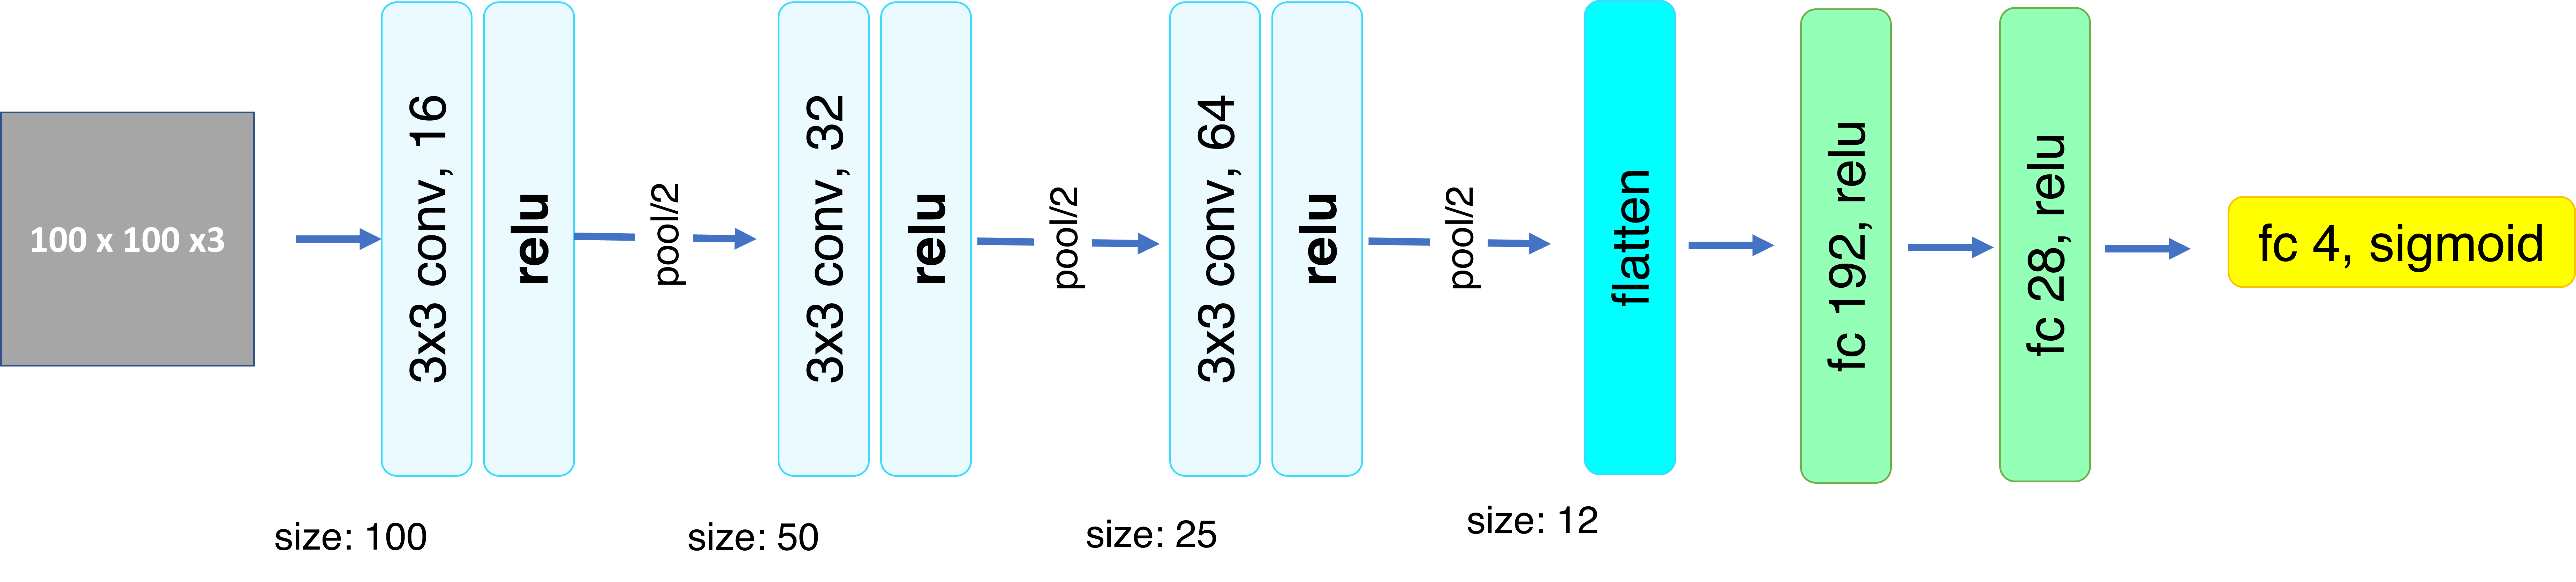

In [25]:
#Develop CNN model in TensorFlow2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [26]:
#cnn
model=Sequential([
    layers.Conv2D(16,3,padding='same',input_shape=(100,100,3),activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(192,activation='relu'),
    layers.Dense(28,activation='relu'),
    layers.Dense(4,activation='sigmoid'),
])

#compiling CNN Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                                 loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [28]:
#train CNN
history=model.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),batch_size=30,epochs=10)

Epoch 1/10
52/52 [==============================] - 25s 390ms/step - loss: 0.4763 - accuracy: 0.8191 - val_loss: 0.2036 - val_accuracy: 0.9304
Epoch 2/10
52/52 [==============================] - 19s 369ms/step - loss: 0.1633 - accuracy: 0.9457 - val_loss: 0.1400 - val_accuracy: 0.9613
Epoch 3/10
52/52 [==============================] - 19s 364ms/step - loss: 0.0876 - accuracy: 0.9774 - val_loss: 0.0659 - val_accuracy: 0.9820
Epoch 4/10
52/52 [==============================] - 19s 369ms/step - loss: 0.0581 - accuracy: 0.9851 - val_loss: 0.0713 - val_accuracy: 0.9691
Epoch 5/10
52/52 [==============================] - 19s 371ms/step - loss: 0.0597 - accuracy: 0.9813 - val_loss: 0.0726 - val_accuracy: 0.9768
Epoch 6/10
52/52 [==============================] - 20s 394ms/step - loss: 0.0281 - accuracy: 0.9942 - val_loss: 0.0660 - val_accuracy: 0.9794
Epoch 7/10
52/52 [==============================] - 20s 393ms/step - loss: 0.0202 - accuracy: 0.9955 - val_loss: 0.1300 - val_accuracy: 0.9613

In [29]:
history_df=pd.DataFrame(history.history)

In [30]:
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.476270,0.819121,0.203601,0.930412
1,0.163348,0.945736,0.139961,0.961340
2,0.087589,0.977390,0.065944,0.981959
3,0.058052,0.985142,0.071278,0.969072
4,0.059690,0.981266,0.072644,0.976804
5,0.028108,0.994186,0.066042,0.979381
6,0.020221,0.995478,0.129983,0.961340
7,0.010066,0.998708,0.069482,0.981959
8,0.022380,0.992248,0.117040,0.963918
9,0.026602,0.990956,0.079967,0.984536


In [31]:
import matplotlib.pyplot as plt

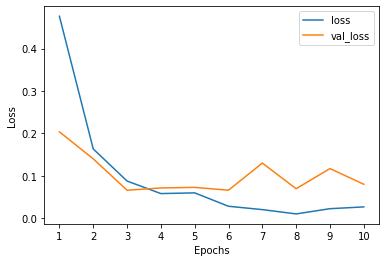

In [32]:
history_df[['loss','val_loss']].plot(kind='line')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(list(range(10)),list(range(1,11)))
plt.show()

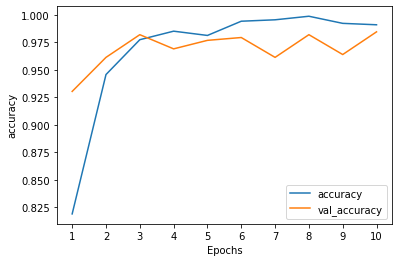

In [33]:
history_df[['accuracy','val_accuracy']].plot(kind='line')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.xticks(list(range(10)),list(range(1,11)))
plt.show()

In [34]:
model.save('face_cnn_model')

INFO:tensorflow:Assets written to: face_cnn_model\assets


In [35]:
one_hot.categories_

[array(['Mask', 'Mask_Chin', 'Mask_Mouth_Chin', 'Mask_Nose_Mouth'],
       dtype='<U15')]

In [36]:
from scipy.special import softmax

In [37]:
#face Detection Model
face_detection_model2=cv2.dnn.readNetFromCaffe('./models-20220206T140731Z-001/models/deploy.prototxt.txt','./models-20220206T140731Z-001/models/res10_300x300_ssd_iter_140000_fp16.caffemodel')

#Mask Detection Model
model=tf.keras.models.load_model('face_cnn_model/')

In [38]:
#Defining labels and set colors
labels=['Mask', 'No Mask', 'Covered Mouth Chin', 'Covered Nose Mouth']
def getColor(label):
    if label=='Mask':
        color=(0,255,0)
    elif label=='No Mask':
        color=(0,0,255)
    elif label=='Covered Mouth Chin':
        color=(0,255,255)
    else:
        color=(255,255,0)
    return color

In [39]:
getColor('Covered Mouth Chin')

(0, 255, 255)

In [40]:
#Recognition Code
#Step-1 Face Detection
def face_mask_prediction(img):
    image=img.copy()
    h,w=image.shape[:2]
    blob=cv2.dnn.blobFromImage(image,1,(300,300),(104,117,123),swapRB=True,)
     #get detections
    face_detection_model2.setInput(blob)
    detections=face_detection_model2.forward()
    for i in range(0,detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>0.5:
            box=detections[0,0,i,3:7]*np.array([w,h,w,h])
            box=box.astype(int)
            pt1=(box[0],box[1])
            pt2=(box[2],box[3])
            #cv2.rectangle(image,pt1,pt2,(0,255,0),2)
                #roi=image[box[1]:box[3],box[0]:box[2]]

            #Step-2 Preprocess data
            #blob from image
            face=image[box[1]:box[3],box[0]:box[2]]
            blob=cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB=True)
            face_squeeze=np.squeeze(blob).T
            face_rotate=cv2.rotate(face_squeeze,cv2.ROTATE_90_CLOCKWISE)
            face_flip=cv2.flip(face_rotate,1)
            #normalize
            img_norm=np.maximum(face_flip,0)/face_flip.max()

            #Step-3 Deep Learning(CNN)
            img_input=img_norm.reshape(1,100,100,3)
            result=model.predict(img_input)
            result=softmax(result)[0]
            confidence_index=result.argmax()
            confidence_score=result[confidence_index]
            label=labels[confidence_index]
            label_text='{} : {:,.0f} % '.format(label,confidence_score*100)
            #print(label_text)
            color=getColor(label)
            cv2.rectangle(image,pt1,pt2,color,2)
            cv2.putText(image,label_text,pt1,cv2.FONT_HERSHEY_PLAIN,2,color,2)
    return image
        



In [ ]:
img=cv2.imread('./women-wearing-mask.jpg')

image=face_mask_prediction(img)
cv2.imshow('Orginal Image',image)
cv2.waitKey()
cv2.destroyAllWindows()

## Real time face mask detection

In [ ]:
cap=cv2.VideoCapture(0)

while True:
    ret, frames=cap.read()
    if ret==False:
        break
    image=face_mask_prediction(frames)
    cv2.imshow('Face Mask Prediction',image)
    if cv2.waitKey(1)==:
        break
        
cap.release()
cap.destroyAllWindows()
    